In [24]:
import sys
import pickle
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import pandas as pd

## Exercise 1

#### CIFAR dataset: 10000 images per batch (n = 10000) with dimensionnality of 32x32x3 (d = 3072) belonging to 10 labels (K = 10)
Taking in the CIFAR dataset and extracting files such that we have: 
 - "X": 3072-by-10000 image pixel data 
 - "y": 10-by-1000 label data
 - "Y": 10-by-1000 one-hot encoded label data

In [25]:
def LoadBatch(file):
    X = unpickle(file)[b'data'].T / 255 # Normalised image inputs
    y = unpickle(file)[b'labels'] # Output labels
    Y = one_hot(y) # One hot encoded output labels
    return X, y, Y

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def one_hot(labels, number_distinct_labels=10):
    labels_one_hot = np.zeros(shape=(number_distinct_labels,len(labels)))
    for i, label in enumerate(labels):
        labels_one_hot[label,i] = 1
    return labels_one_hot

In [26]:
# Training data
X_1, y_1, Y_1 = LoadBatch('cifar-10-batches-py/data_batch_1')
X_2, y_2, Y_2 = LoadBatch('cifar-10-batches-py/data_batch_2')

# Test data
X_t, y_t, Y_t = LoadBatch('cifar-10-batches-py/test_batch')

batches = unpickle('cifar-10-batches-py/batches.meta')

label_names = [label_name.decode('utf-8') for label_name in batches[b'label_names']]
print(label_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [27]:
print("Input image matrix "+ str(X_1.shape) + ":")
print(X_1)
print("-----")
print("Output one-hot matrix "+ str(Y_1.shape) + ":")
print(Y_1)

Input image matrix (3072, 10000):
[[0.23137255 0.60392157 1.         ... 0.27843137 0.98039216 0.24313725]
 [0.16862745 0.49411765 0.99215686 ... 0.23529412 0.99607843 0.23921569]
 [0.19607843 0.41176471 0.99215686 ... 0.29019608 0.82745098 0.23529412]
 ...
 [0.54901961 0.54509804 0.3254902  ... 0.26666667 0.84313725 0.50980392]
 [0.32941176 0.55686275 0.3254902  ... 0.27058824 1.         0.50980392]
 [0.28235294 0.56470588 0.32941176 ... 0.26666667 0.99607843 0.51372549]]
-----
Output one-hot matrix (10, 10000):
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 1. 1. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 1. 1. ... 0. 0. 0.]]


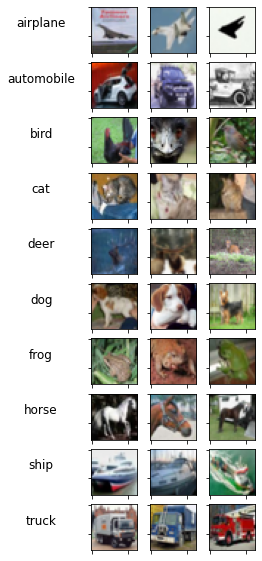

In [28]:
fig, axes = plt.subplots(nrows=10, ncols=3, figsize=(3,10))

for label_idx, label_name in enumerate(label_names):
    X = X_t[:,np.equal(y_t, label_idx)][:,0:3]
    for image_idx, image in enumerate(X.T):
        axes[label_idx][image_idx].imshow(image.reshape(3,32,32).transpose([1,2,0]))
        axes[label_idx][image_idx].tick_params(labelbottom=False, labelleft=False)
    axes[label_idx][0].set_ylabel(label_name, labelpad=50, rotation=0, size='large')

#### Preprocessing the data: Compute the mean and standard deviation vector for the training data and then normalize the training, validation and test data w.r.t. these mean and standard deviation vectors.

In [29]:
def preprocess_images(X, mean, std): 
    
    if mean is None and std is None:
        mean = np.mean(X, axis=0)  # Mean of the columns
        std = np.std(X, axis=0)  # Std of the columns
        
    X -= mean
    X /= std
        
    return X, mean, std

In [30]:
X_train, train_mean, train_std = preprocess_images(X_1, mean = None, std = None)
X_val, val_mean, val_std = preprocess_images(X_2, mean = train_mean, std = train_std)
X_test, test_mean, test_std = preprocess_images(X_t, mean = train_mean, std = train_std)

print(np.mean(X_train, axis=0))

[-7.40148683e-17 -4.30211422e-16  2.77555756e-16 ... -7.40148683e-17
 -2.12792746e-16  2.12792746e-16]


In [31]:
print(X_1.shape, X_train.shape)
print(X_2.shape, X_val.shape)
print(X_t.shape, X_test.shape)

(3072, 10000) (3072, 10000)
(3072, 10000) (3072, 10000)
(3072, 10000) (3072, 10000)


#### Initializing the weights and biases.

In [32]:
def initialize_weights(input_dim, hidden_dim, output_dim, seed=42):
    np.random.seed(seed)
    # Weights initialising
    W_1 = np.random.normal(0, 1/np.sqrt(input_dim), (hidden_dim, input_dim))
    W_2 = np.random.normal(0, 1/np.sqrt(hidden_dim), (output_dim, hidden_dim))
    # Bias initializing
    b_1 = np.zeros((hidden_dim, 1))
    b_2 = np.zeros((output_dim, 1))
    return W_1, W_2, b_1, b_2

In [33]:
# Initializing weight and bias matrix with appropriate dimensions

input_dim = X_1.shape[0] 
hidden_dimm = 50
output_dim = Y_1.shape[0]

W_1, W_2, b_1, b_2 = initialize_weights(input_dim, hidden_dimm, output_dim)

print(W_1.shape, W_2.shape, b_1.shape, b_2.shape)

(50, 3072) (10, 50) (50, 1) (10, 1)


## Exercise 2

In [34]:
def softmax(S):
    return np.exp(S) / np.exp(S).sum(axis=0)
    
def EvaluateClassifier(X, W_1, W_2, b_1, b_2):
    s_1 = np.dot(W_1, X) + b_1
    h = np.maximum(0, s_1)
    s = np.dot(W_2, h) + b_2
    p = softmax(s)
    
    return p, h

In [35]:
subset_size = 100
p, h = EvaluateClassifier(X_train[:,0:subset_size], W_1, W_2, b_1, b_2)

print(p.shape, h.shape)

(10, 100) (50, 100)


#### Computing the cost function for cross entropy loss with L2 regularization.

In [36]:
def ComputeCost(X, Y, W_1, W_2, b_1, b_2, λ):
    # Compute network output
    P, H = EvaluateClassifier(X, W_1, W_2, b_1, b_2)
    # Compute loss function term
    L = sum(-np.log((Y*P).sum(axis=0)))
    # Compute regularization term
    L_λ = λ*((W_1**2).sum() + (W_2**2).sum())
    # Compute total cost
    J = L/X.shape[1] + L_λ
    return J

#### Computing the accuracy of the network's predictions where accuracy = % of correctly classified images.

In [37]:
def ComputeAccuracy(X, y, W_1, W_2, b_1, b_2):
    # Compute network output
    P, H = EvaluateClassifier(X, W_1, W_2, b_1, b_2)
    # Compute the accuracy
    acc = np.mean(y==np.argmax(P, 0))
    return acc

#### Computing the gradients of the cost function w.r.t W and b analytically.

In [38]:
def ComputeGradients(X, Y, P, H, W_1, W_2, λ):
    n = X.shape[1]
    G = -(Y-P)
    grad_W_2 = np.dot(G, H.T)/n+2*λ*W_2
    grad_b_2 = (np.dot(G, np.ones(shape=(n,1)))/n).reshape(Y.shape[0], 1)
    G = np.dot(W_2.T,G) * (H>0)
    grad_W_1 = np.dot(G, X.T)/n+2*λ*W_1
    grad_b_1 = (np.dot(G, np.ones(shape=(n,1)))/n).reshape(H.shape[0], 1)
    return grad_W_1, grad_W_2, grad_b_1, grad_b_2

#### Comparing results with gradients computed numerically.

In [39]:
def ComputeGradsNum(X, Y, W1, b1, W2, b2, lambda_, h=0.00001):
    grad_W2 = np.zeros(shape=W2.shape)
    grad_b2 = np.zeros(shape=b2.shape)
    grad_W1 = np.zeros(shape=W1.shape)
    grad_b1 = np.zeros(shape=b1.shape)   
    c = ComputeCost(X, Y, W1, W2, b1, b2, lambda_)
    
    for i in range(b1.shape[0]):
        b1_try = b1.copy()
        b1_try[i,0] = b1_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, W2, b1_try, b2, lambda_)
        grad_b1[i,0] = (c2-c)/h
    
    for i in range(W1.shape[0]):
        for j in range(W1.shape[1]):
            W1_try = W1.copy()
            W1_try[i,j] = W1_try[i,j]+h
            c2 = ComputeCost(X, Y, W1_try, W2, b1, b2, lambda_)
            grad_W1[i,j] = (c2-c)/h
    
    for i in range(b2.shape[0]):
        b2_try = b2.copy()
        b2_try[i,0] = b2_try[i,0]+h
        c2 = ComputeCost(X, Y, W1, W2, b1, b2_try, lambda_)
        grad_b2[i,0] = (c2-c)/h
    
    for i in range(W2.shape[0]):
        for j in range(W2.shape[1]):
            W2_try = W2.copy()
            W2_try[i,j] = W2_try[i,j]+h
            c2 = ComputeCost(X, Y, W1, W2_try, b1, b2, lambda_)
            grad_W2[i,j] = (c2-c)/h
    
    return grad_W2, grad_b2, grad_W1, grad_b1

In [40]:
X = X_1[0:20,[0]]
Y = Y_1[:,[0]]
λ = 0

# Computing the gradients analytically
P, H = EvaluateClassifier(X, W_1[:,0:20], W_2, b_1, b_2)
grad_W_1_ana, grad_W_2_ana, grad_b_1_ana, grad_b_2_ana = ComputeGradients(X, Y, P, H, W_1[:,0:20], W_2, λ)

# Computing the gradients numerically
grad_W_2_num, grad_b_2_num, grad_W_1_num, grad_b_1_num = ComputeGradsNum(X, Y, W_1[:,0:20], b_1, W_2, b_2, λ)


# Absolute error between both gradients
grad_W1_abs_diff = np.abs(grad_W_1_num - grad_W_1_ana)
grad_b1_abs_diff = np.abs(grad_b_1_num - grad_b_1_ana)
grad_W2_abs_diff = np.abs(grad_W_2_num - grad_W_2_ana)
grad_b2_abs_diff = np.abs(grad_b_2_num - grad_b_2_ana)

W_1_error, W_2_error = np.mean(grad_W1_abs_diff<1e-6)*100, np.mean(grad_W2_abs_diff<1e-6)*100
b_1_error, b_2_error = np.mean(grad_b1_abs_diff<1e-6)*100, np.mean(grad_b2_abs_diff<1e-6)*100

W_1_max_error, W_2_max_error = grad_W1_abs_diff.max(), grad_W2_abs_diff.max()
b_1_max_error, b_2_max_error = grad_b1_abs_diff.max(), grad_b2_abs_diff.max()

print("Percentage of weight 1 errors < 1e-6:", W_1_error)
print("Percentage of weight 2 errors < 1e-6:", W_2_error)
print("Percentage of bias 1 errors < 1e-6:", b_1_error)
print("Percentage of bias 2 errors < 1e-6:", b_2_error)
print("Max weight 1 error:", W_1_max_error)
print("Max weight 2 error:", W_2_max_error)
print("Max bias 1 error:", b_1_max_error)
print("Max bias 2 error:", b_2_max_error)

Percentage of weight 1 errors < 1e-6: 100.0
Percentage of weight 2 errors < 1e-6: 100.0
Percentage of bias 1 errors < 1e-6: 100.0
Percentage of bias 2 errors < 1e-6: 100.0
Max weight 1 error: 2.1387933624161803e-07
Max weight 2 error: 3.803785206951682e-09
Max bias 1 error: 1.581129628058786e-07
Max bias 2 error: 4.7170880906888257e-07


## Exercise 3

#### Performing the mini-batch gradient descent algorithm with cyclical learning rates.

In [41]:
# Mini-batch gradient descent algorithm
def MiniBatchGD(X, Y, y, X_val, Y_val, y_val, W_1, W_2, b_1, b_2, GDparams, λ):
    
    n = X.shape[1]
    
    n_batch = GDparams['n_batch']
    n_cycles = GDparams['n_cycles']
    step_size = GDparams['step_size']
    eta_min = GDparams['eta_min']
    eta_max = GDparams['eta_max']
    eta_min_max = eta_max-eta_min
    
    # Creating copy of parameters to be updated
    W_1, W_2, b_1, b_2 = W_1.copy(), W_2.copy(), b_1.copy(), b_2.copy()
    
    # Measured metrics
    updates = []
    loss_train = []
    acc_train = []
    loss_val = []
    acc_val = []
    etas = []
    update_step = []

    # Get batches
    data_batches = {}
    for j in range(n//n_batch):
        j_start = j*n_batch
        j_end = (j+1)*n_batch
        inds = range(j_start, j_end)
        data_batches[j] = (X[:,inds], Y[:,inds], [y[index] for index in inds])
        
    # Iterate through cycles
    batch_idx = 0
    for cycle in range(n_cycles):
        
        incr_cycle = 2*cycle*step_size
        decr_cycle = 2*(cycle+1)*step_size
        half_cycle = (2*cycle+1)*step_size

        # Iterate through update steps
        for i in range(incr_cycle, decr_cycle):

            # Increasing half of eta cycle
            if i >= incr_cycle and i < half_cycle:
                eta = eta_min+(i-incr_cycle)/step_size*eta_min_max
            # Decreasing half of eta cycle
            elif i >= half_cycle and i < decr_cycle:
                eta = eta_max-(i-half_cycle)/step_size*eta_min_max
        
            etas.append(eta)
            update_step.append(i+1)

            # Updating network weights and biases
            X_batch, Y_batch, y_batch = data_batches[batch_idx]
            P_batch, H_batch = EvaluateClassifier(X_batch, W_1, W_2, b_1, b_2)

            grad_W_1, grad_W_2, grad_b_1, grad_b_2 = ComputeGradients(X_batch, Y_batch, P_batch, H_batch, W_1, W_2, λ)
            
            W_1 -= eta * grad_W_1
            W_2 -= eta * grad_W_2
            b_1 -= eta * grad_b_1
            b_2 -= eta * grad_b_2
            
            batch_idx += 1
            
            if batch_idx>(n//n_batch-1):
                batch_idx = 0
                
                # Save learning metrics for plotting
                updates.append(i+1)
                acc_train.append(ComputeAccuracy(X, y, W_1, W_2, b_1, b_2))
                loss_train.append(ComputeCost(X, Y, W_1, W_2, b_1, b_2, λ))
                acc_val.append(ComputeAccuracy(X_val, y_val, W_1, W_2, b_1, b_2))
                loss_val.append(ComputeCost(X_val, Y_val,  W_1, W_2, b_1, b_2, λ))
                
                # Logging
                sys.stdout.write("Update: " + str(i+1) + ", Epoch: " +  str(len(updates)-1) + 
                                 " -> training loss:" + str(loss_train[-1]) + ", training accuracy:" + str(acc_train[-1]) + "\r")

    return W_1, W_2, b_1, b_2, loss_train, acc_train, loss_val, acc_val, etas, updates

In [42]:
# Function to plot the loss and accuracy learning curves
def plot_learning_curve(updates, loss_train, acc_train, loss_val, acc_val, check = False):
    
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
    fig.suptitle('Learning curves')
    
    if check == True:
        ax1.plot(updates, loss_train, label = "Training loss", color = "green")
        ax2.plot(updates, acc_train, label = "Training accuracy", color = "green")
    else:
        ax1.plot(updates, loss_train, label = "Training loss", color = "green")
        ax2.plot(updates, acc_train, label = "Training accuracy", color = "green")
        ax1.plot(updates, loss_val, label = "Validation loss", color = "red")   
        ax2.plot(updates, acc_val, label = "Validation accuracy", color = "red")
    
    ax1.set_xlabel("Updates")
    ax2.set_xlabel("Updates")
    ax1.set_ylabel("Loss")
    ax2.set_ylabel("Accuracy")
    
    ax1.grid(True)
    ax2.grid(True)
    ax1.legend()
    ax2.legend()

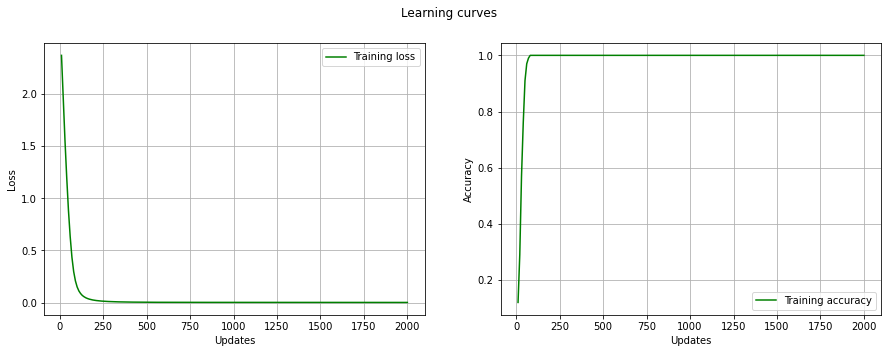

In [43]:
# Model parameters
X, Y, y = X_train[:,0:100], Y_1[:,0:100], y_1[0:100]
λ_check = 0
GDparams_check = {'n_batch':10, 'n_cycles':2, 'step_size':500, 'eta_min':1e-5, 'eta_max':1e-1}

# Training the model
W_1_check, W_2_check, b_1_check, b_2_check, loss_train_check, acc_train_check, loss_val_check, acc_val_check, etas_check, update_step_check = \
    MiniBatchGD(X, Y, y, X_val, Y_2, y_2, W_1, W_2, b_1, b_2, GDparams_check, λ_check)

# Plot learning curve
plot_learning_curve(update_step_check, loss_train_check, acc_train_check, loss_val_check, acc_val_check, check = True)

## Exercise 4

#### Figure 3 model parameters

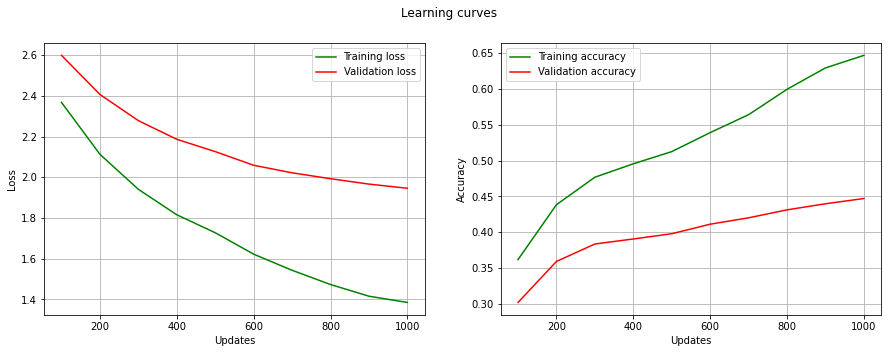

In [44]:
# FIGURE 3: Model parameters
λ_3 = 0.01
GDparams_3 = {'n_batch':100, 'n_cycles':1, 'step_size':500, 'eta_min':1e-5, 'eta_max':1e-1}

# Training the model
W_1_3, W_2_3, b_1_3, b_2_3, loss_train_3, acc_train_3, loss_val_3, acc_val_3, etas_3, update_step_3 = \
    MiniBatchGD(X_train, Y_1, y_1, X_val, Y_2, y_2, W_1, W_2, b_1, b_2, GDparams_3, λ_3)

# Plot learning curve
plot_learning_curve(update_step_3, loss_train_3, acc_train_3, loss_val_3, acc_val_3)

In [46]:
print(acc_val_3[-1])

0.4471


#### Figure 4 model parameters

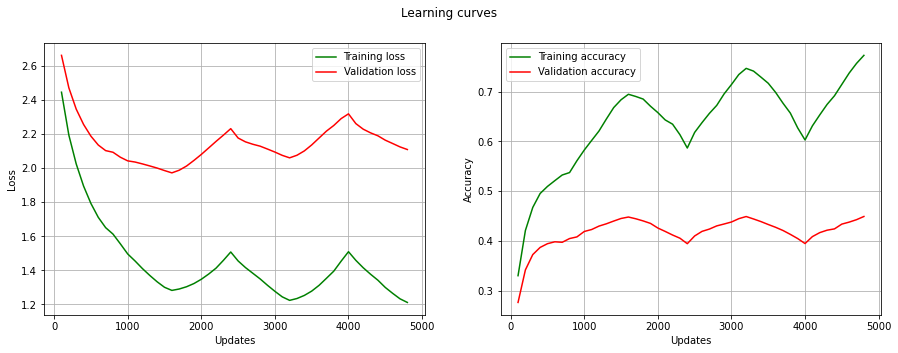

In [45]:
# FIGURE 4: Model parameters
λ_4 = 0.01
GDparams_4 = {'n_batch':100, 'n_cycles':3, 'step_size':800, 'eta_min':1e-5, 'eta_max':1e-1}

# Training the model
W_1_4, W_2_4, b_1_4, b_2_4, loss_train_4, acc_train_4, loss_val_4, acc_val_4, etas_4, update_step_4 = \
    MiniBatchGD(X_train, Y_1, y_1, X_val, Y_2, y_2, W_1, W_2, b_1, b_2, GDparams_4, λ_4)

# Plot learning curve
plot_learning_curve(update_step_4, loss_train_4, acc_train_4, loss_val_4, acc_val_4)

In [47]:
print(acc_val_4[-1])

0.4494


### Coarse-to-fine random search to set λ

#### Need 5 training batches for training

In [48]:
# Training data
X_1, y_1, Y_1 = LoadBatch('cifar-10-batches-py/data_batch_1')
X_2, y_2, Y_2 = LoadBatch('cifar-10-batches-py/data_batch_2')
X_3, y_3, Y_3 = LoadBatch('cifar-10-batches-py/data_batch_3')
X_4, y_4, Y_4 = LoadBatch('cifar-10-batches-py/data_batch_4')
X_5, y_5, Y_5 = LoadBatch('cifar-10-batches-py/data_batch_5')

X = np.hstack((X_1, X_2, X_3, X_4, X_5))
y = y_1 + y_2 + y_3 + y_4 + y_5
Y = np.hstack((Y_1, Y_2, Y_3, Y_4, Y_5))

# Get 5000 images for validation set
np.random.seed(0)
idx_val = np.random.choice(range(X.shape[1]), 5000, replace=False)
X_val = X[:,idx_val]
y_val = [y[i] for i in idx_val]
Y_val = Y[:,idx_val]

# Keep 45000 images for training set
X_train = np.delete(X, idx_val, 1)
y_train = [y[i] for i in range(X.shape[1]) if i not in idx_val]
Y_train = np.delete(Y, idx_val, 1)

# Data normalization
std = X_train.std(axis=1).reshape(X_train.shape[0], 1)
mean = X_train.mean(axis=1).reshape(X_train.shape[0], 1)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

print("--- Training ---")
print(X_train.shape)
print(len(y_train))
print(Y_train.shape)
print("\n--- Validation ---")
print(X_val.shape)
print(len(y_val))
print(Y_val.shape)

--- Training ---
(3072, 45000)
45000
(10, 45000)

--- Validation ---
(3072, 5000)
5000
(10, 5000)


In [49]:
# Function that performs mini batch GD with different values of lambda
def λ_search(X_train, Y_train, y_train, X_val, Y_val, y_val, hidden_dim, GDparams, λ_list, n_init):
    
    λs = []
    loss_train_mean = []
    acc_train_mean = []
    loss_val_mean = []
    acc_val_mean = []
    
    # iterate through different values of λ
    for λ in tqdm(λ_list):
        
        loss_train_λ = []
        acc_train_λ = []
        loss_val_λ = []
        acc_val_λ = []
        
        # iterate for different initializations of the network
        for init in range(n_init):
        
            W_1, W_2, b_1, b_2 = initialize_weights(X_train.shape[0], hidden_dim, Y_train.shape[0], seed=init)
            W_1, W_2, b_1, b_2, loss_train, acc_train, loss_val, acc_val, etas, updates = MiniBatchGD(X_train, Y_train, y_train, X_val, Y_val, y_val, W_1, W_2, b_1, b_2, GDparams, λ)
            
            # Saving metric for each initialisation
            loss_train_λ.append(loss_train[-1])
            acc_train_λ.append(acc_train[-1])
            loss_val_λ.append(loss_val[-1])
            acc_val_λ.append(acc_val[-1])
            
        # Getting average performance for λ
        λs.append(λ)
        # Train
        loss_train_mean.append(np.mean(loss_train_λ))
        acc_train_mean.append(np.mean(acc_train_λ))
        # Val
        loss_val_mean.append(np.mean(loss_val_λ))
        acc_val_mean.append(np.mean(acc_val_λ))
        
    return λs, loss_train_mean, acc_train_mean, loss_val_mean, acc_val_mean

In [50]:
# list of lambdas
np.random.seed(42)
l_max, l_min = -1, -5
l = l_min + (l_max-l_min) * np.random.rand(10)
list_λ_coarse = list(10 ** l)
list_λ_coarse.sort()
print(list_λ_coarse)

[1.7073967431528134e-05, 4.20705395028794e-05, 4.2079886696066304e-05, 0.000314891164795686, 0.0024810409748678096, 0.0025378155082656628, 0.006796578090758151, 0.008471801418819973, 0.029154431891537522, 0.06351221010640692]


In [51]:
# Performing course λ search
n_batch = 100
GDparams_λ_search = {'n_batch':n_batch, 'n_cycles':2, 'step_size':int(2*X_train.shape[1]/n_batch), 'eta_min':1e-5, 'eta_max':1e-1}

λs, loss_train_mean, acc_train_mean, loss_val_mean, acc_val_mean = \
    λ_search(X_train, Y_train, y_train, X_val, Y_val, y_val, hidden_dim = 50, GDparams = GDparams_λ_search, λ_list = list_λ_coarse, n_init = 5)


  0%|          | 0/10 [00:00<?, ?it/s]

 10%|█         | 1/10 [01:34<14:07, 94.14s/it]

 20%|██        | 2/10 [03:07<12:30, 93.78s/it]

 30%|███       | 3/10 [04:40<10:53, 93.37s/it]

 40%|████      | 4/10 [06:12<09:16, 92.78s/it]

 50%|█████     | 5/10 [07:44<07:42, 92.44s/it]

 60%|██████    | 6/10 [09:15<06:08, 92.14s/it]

 70%|███████   | 7/10 [10:46<04:35, 91.75s/it]

 80%|████████  | 8/10 [12:23<03:06, 93.44s/it]

 90%|█████████ | 9/10 [14:05<01:35, 95.91s/it]

100%|██████████| 10/10 [15:38<00:00, 93.90s/it]

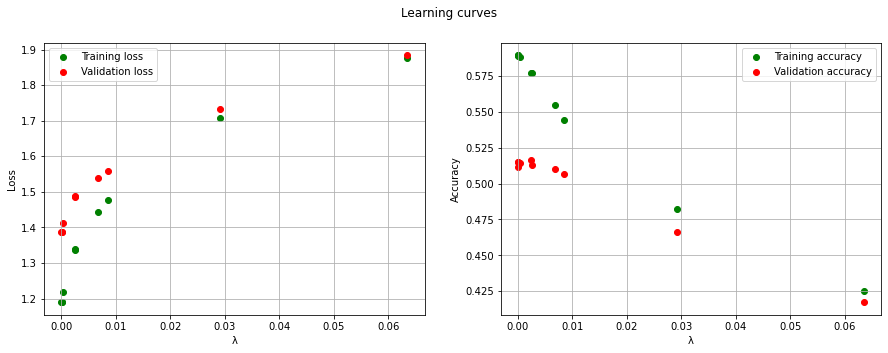

In [52]:
# Plotting performance for each λ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Learning curves')

ax1.scatter(λs, loss_train_mean, label = "Training loss", color = "green")
ax2.scatter(λs, acc_train_mean, label = "Training accuracy", color = "green")
ax1.scatter(λs, loss_val_mean, label = "Validation loss", color = "red")   
ax2.scatter(λs, acc_val_mean, label = "Validation accuracy", color = "red")

ax1.set_xlabel("λ")
ax2.set_xlabel("λ")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")

ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()

In [53]:
print(λs)
print(acc_val_mean)

max_acc_val = max(acc_val_mean)
best_λ_index = acc_val_mean.index(max_acc_val)
best_λ = λs[best_λ_index]

print("\nBest λ:", best_λ)

[1.7073967431528134e-05, 4.20705395028794e-05, 4.2079886696066304e-05, 0.000314891164795686, 0.0024810409748678096, 0.0025378155082656628, 0.006796578090758151, 0.008471801418819973, 0.029154431891537522, 0.06351221010640692]
[0.51176, 0.51508, 0.51536, 0.5144399999999999, 0.51616, 0.5131600000000001, 0.50988, 0.50668, 0.46648000000000006, 0.41716]

Best λ: 0.0024810409748678096


### Fine random search to set λ

In [54]:
list_λ_fine = np.arange(0, 0.005, 0.001)
list_λ_fine

array([0.   , 0.001, 0.002, 0.003, 0.004])

In [55]:
# Performing fine λ search
n_batch = 100
GDparams_λ_search = {'n_batch':n_batch, 'n_cycles':2, 'step_size':int(2*X_train.shape[1]/n_batch), 'eta_min':1e-5, 'eta_max':1e-1}

λs, loss_train_mean, acc_train_mean, loss_val_mean, acc_val_mean = \
    λ_search(X_train, Y_train, y_train, X_val, Y_val, y_val, hidden_dim = 50, GDparams = GDparams_λ_search, λ_list = list_λ_fine, n_init = 5)

  0%|          | 0/5 [00:00<?, ?it/s]

 20%|██        | 1/5 [01:31<06:04, 91.11s/it]

 40%|████      | 2/5 [03:04<04:37, 92.46s/it]

 60%|██████    | 3/5 [04:38<03:06, 93.24s/it]

 80%|████████  | 4/5 [06:13<01:33, 93.85s/it]

100%|██████████| 5/5 [07:46<00:00, 93.38s/it]

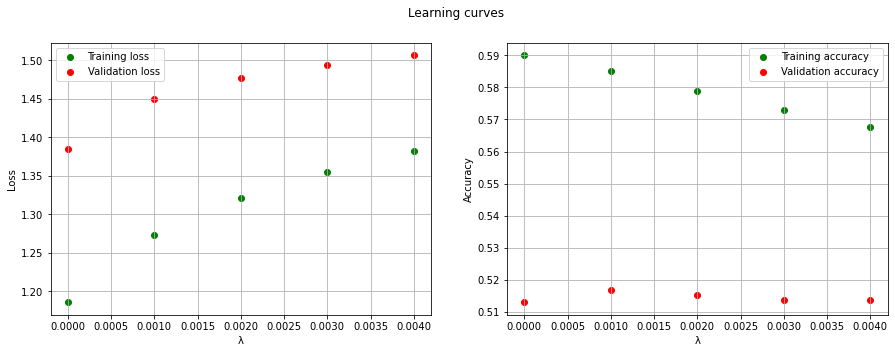

In [56]:
# Plotting performance for each λ
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))
fig.suptitle('Learning curves')

ax1.scatter(λs, loss_train_mean, label = "Training loss", color = "green")
ax2.scatter(λs, acc_train_mean, label = "Training accuracy", color = "green")
ax1.scatter(λs, loss_val_mean, label = "Validation loss", color = "red")   
ax2.scatter(λs, acc_val_mean, label = "Validation accuracy", color = "red")

ax1.set_xlabel("λ")
ax2.set_xlabel("λ")
ax1.set_ylabel("Loss")
ax2.set_ylabel("Accuracy")

ax1.grid(True)
ax2.grid(True)
ax1.legend()
ax2.legend()

In [57]:
print(λs)
print(acc_val_mean)

max_acc_val = max(acc_val_mean)
best_λ_index = acc_val_mean.index(max_acc_val)
best_λ = λs[best_λ_index]

print("\nBest λ:", best_λ)

[0.0, 0.001, 0.002, 0.003, 0.004]
[0.51288, 0.51688, 0.5151600000000001, 0.51364, 0.5136000000000001]

Best λ: 0.001


### Training and plotting learning curves using best found λ

In [59]:
# Training data
X_1, y_1, Y_1 = LoadBatch('cifar-10-batches-py/data_batch_1')
X_2, y_2, Y_2 = LoadBatch('cifar-10-batches-py/data_batch_2')
X_3, y_3, Y_3 = LoadBatch('cifar-10-batches-py/data_batch_3')
X_4, y_4, Y_4 = LoadBatch('cifar-10-batches-py/data_batch_4')
X_5, y_5, Y_5 = LoadBatch('cifar-10-batches-py/data_batch_5')

X = np.hstack((X_1, X_2, X_3, X_4, X_5))
y = y_1 + y_2 + y_3 + y_4 + y_5
Y = np.hstack((Y_1, Y_2, Y_3, Y_4, Y_5))

# Get 5000 images for validation set
np.random.seed(0)
idx_val = np.random.choice(range(X.shape[1]), 1000, replace=False)
X_val = X[:,idx_val]
y_val = [y[i] for i in idx_val]
Y_val = Y[:,idx_val]

# Keep 45000 images for training set
X_train = np.delete(X, idx_val, 1)
y_train = [y[i] for i in range(X.shape[1]) if i not in idx_val]
Y_train = np.delete(Y, idx_val, 1)

# Data normalization
std = X_train.std(axis=1).reshape(X_train.shape[0], 1)
mean = X_train.mean(axis=1).reshape(X_train.shape[0], 1)
X_train = (X_train - mean) / std
X_val = (X_val - mean) / std

print("--- Training ---")
print(X_train.shape)
print(len(y_train))
print(Y_train.shape)
print("\n--- Validation ---")
print(X_val.shape)
print(len(y_val))
print(Y_val.shape)

--- Training ---
(3072, 49000)
49000
(10, 49000)

--- Validation ---
(3072, 1000)
1000
(10, 1000)


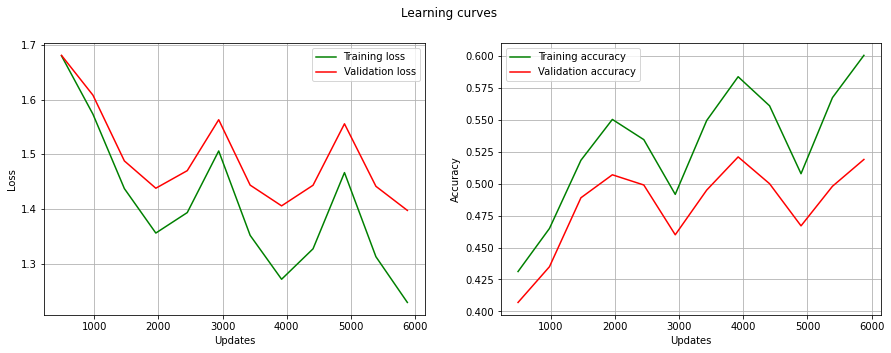

In [60]:
best_overall_λ = best_λ
n_batch = 100
GDparams_λ_best = {'n_batch':n_batch, 'n_cycles':3, 'step_size':int(2*X_train.shape[1]/n_batch), 'eta_min':1e-5, 'eta_max':1e-1}

# Training the model
W_1_best, W_2_best, b_1_best, b_2_best, loss_train_best, acc_train_best, loss_val_best, acc_val_best, etas_best, update_step_best = \
    MiniBatchGD(X_train, Y_train, y_train, X_val, Y_val, y_val, W_1, W_2, b_1, b_2, GDparams_λ_best, best_overall_λ)

# Plot learning curve
plot_learning_curve(update_step_best, loss_train_best, acc_train_best, loss_val_best, acc_val_best)

In [61]:
print(acc_val_best[-1])

0.519
